In [1]:
import pandas as pd
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import confusion_matrix
# import graphviz
from matplotlib import pyplot
from xgboost import plot_tree
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import codecs  
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import cohen_kappa_score
# from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import LabelEncoder

In [2]:
data = pd.read_csv('./data/used_car_train_20200313.csv',sep = ' ')

In [3]:
data.head()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
0,0,736,20040402,30.0,6,1.0,0.0,0.0,60,12.5,...,0.235676,0.101988,0.129549,0.022816,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914762
1,1,2262,20030301,40.0,1,2.0,0.0,0.0,0,15.0,...,0.264777,0.121004,0.135731,0.026597,0.020582,-4.900482,2.096338,-1.030483,-1.722674,0.245522
2,2,14874,20040403,115.0,15,1.0,0.0,0.0,163,12.5,...,0.251410,0.114912,0.165147,0.062173,0.027075,-4.846749,1.803559,1.565330,-0.832687,-0.229963
3,3,71865,19960908,109.0,10,0.0,0.0,1.0,193,15.0,...,0.274293,0.110300,0.121964,0.033395,0.000000,-4.509599,1.285940,-0.501868,-2.438353,-0.478699
4,4,111080,20120103,110.0,5,1.0,0.0,0.0,68,5.0,...,0.228036,0.073205,0.091880,0.078819,0.121534,-1.896240,0.910783,0.931110,2.834518,1.923482


In [6]:
data.dtypes

SaleID                 int64
name                   int64
regDate                int64
model                float64
brand                  int64
bodyType             float64
fuelType             float64
gearbox              float64
power                  int64
kilometer            float64
notRepairedDamage     object
regionCode             int64
seller                 int64
offerType              int64
creatDate              int64
price                  int64
v_0                  float64
v_1                  float64
v_2                  float64
v_3                  float64
v_4                  float64
v_5                  float64
v_6                  float64
v_7                  float64
v_8                  float64
v_9                  float64
v_10                 float64
v_11                 float64
v_12                 float64
v_13                 float64
v_14                 float64
dtype: object

In [7]:
data.notRepairedDamage.unique()

array(['0.0', '-', '1.0'], dtype=object)

In [8]:
encoder = LabelEncoder()
encoder.fit_transform(data.notRepairedDamage)

array([1, 0, 1, ..., 1, 1, 1])

In [9]:
data_clean = data.copy()
data_clean['notRepairedDamage'] = encoder.fit_transform(data.notRepairedDamage)

In [10]:
data_clean.describe()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
count,150000.000000,150000.000000,1.500000e+05,149999.000000,150000.000000,145494.000000,141320.000000,144019.000000,150000.000000,150000.000000,...,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000
mean,74999.500000,68349.172873,2.003417e+07,47.129021,8.052733,1.792369,0.375842,0.224943,119.316547,12.597160,...,0.248204,0.044923,0.124692,0.058144,0.061996,-0.001000,0.009035,0.004813,0.000313,-0.000688
std,43301.414527,61103.875095,5.364988e+04,49.536040,7.864956,1.760640,0.548677,0.417546,177.168419,3.919576,...,0.045804,0.051743,0.201410,0.029186,0.035692,3.772386,3.286071,2.517478,1.288988,1.038685
min,0.000000,0.000000,1.991000e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-9.168192,-5.558207,-9.639552,-4.153899,-6.546556
25%,37499.750000,11156.000000,1.999091e+07,10.000000,1.000000,0.000000,0.000000,0.000000,75.000000,12.500000,...,0.243615,0.000038,0.062474,0.035334,0.033930,-3.722303,-1.951543,-1.871846,-1.057789,-0.437034
50%,74999.500000,51638.000000,2.003091e+07,30.000000,6.000000,1.000000,0.000000,0.000000,110.000000,15.000000,...,0.257798,0.000812,0.095866,0.057014,0.058484,1.624076,-0.358053,-0.130753,-0.036245,0.141246
75%,112499.250000,118841.250000,2.007111e+07,66.000000,13.000000,3.000000,1.000000,0.000000,150.000000,15.000000,...,0.265297,0.102009,0.125243,0.079382,0.087491,2.844357,1.255022,1.776933,0.942813,0.680378
max,149999.000000,196812.000000,2.015121e+07,247.000000,39.000000,7.000000,6.000000,1.000000,19312.000000,15.000000,...,0.291838,0.151420,1.404936,0.160791,0.222787,12.357011,18.819042,13.847792,11.147669,8.658418


In [39]:
X  = data_clean.drop(labels = ['SaleID','price','name'],axis = 1)
y = data_clean.price
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size = 0.3, random_state = 0, shuffle = True)

In [40]:
X_train.shape,X_test.shape

((105000, 28), (45000, 28))

In [41]:
xgb_reg = xgb.XGBRegressor(silent=False,
                           learning_rate=0.1,
                           colsample_bytree=0.7,
                           subsample=0.8,
                           objective='reg:linear',
                           n_estimators=3000,
                           reg_alpha=0.3,
                           max_depth=5,
                           gamma=5,
                           eval_metric=['mae'],
                           n_jobs = -1)

In [45]:
eval_set = [(X_train, y_train), (X_test, y_test)]
eval_metric = ["mae"]
xgb_reg.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, verbose=True,early_stopping_rounds= 100)

[08:38:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[0]	validation_0-mae:5314.02	validation_1-mae:5369
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 100 rounds.
[08:38:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[1]	validation_0-mae:4785.24	validation_1-mae:4834.21
[08:38:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[2]	validation_0-mae:4310.27	validation_1-mae:4354.81
[08:38:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[3]	validation_0-mae:3886.08	validation_1-mae:3926.32
[08:38:29] C:\Users\Admin

[08:38:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[40]	validation_0-mae:775.213	validation_1-mae:813.015
[08:38:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[41]	validation_0-mae:772.088	validation_1-mae:810.021
[08:38:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[42]	validation_0-mae:769.663	validation_1-mae:807.777
[08:38:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[43]	validation_0-mae:766.97	validation_1-mae:805.233
[08:38:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[44]	validation_0-mae:764.

[08:38:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[80]	validation_0-mae:699.068	validation_1-mae:747.371
[08:38:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[81]	validation_0-mae:697.776	validation_1-mae:746.193
[08:38:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[82]	validation_0-mae:696.81	validation_1-mae:745.417
[08:38:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[83]	validation_0-mae:695.857	validation_1-mae:744.786
[08:38:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[84]	validation_0-mae:695.

[08:38:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[120]	validation_0-mae:663.99	validation_1-mae:720.088
[08:38:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[121]	validation_0-mae:663.766	validation_1-mae:720.029
[08:38:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[122]	validation_0-mae:663.123	validation_1-mae:719.638
[08:38:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[123]	validation_0-mae:661.62	validation_1-mae:718.303
[08:38:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[124]	validation_0-mae:

[159]	validation_0-mae:635.586	validation_1-mae:698.065
[08:38:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[160]	validation_0-mae:634.422	validation_1-mae:697.092
[08:38:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[161]	validation_0-mae:633.866	validation_1-mae:696.714
[08:38:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[162]	validation_0-mae:632.522	validation_1-mae:695.413
[08:38:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[163]	validation_0-mae:632.113	validation_1-mae:695.126
[08:38:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra 

[08:38:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[200]	validation_0-mae:611.14	validation_1-mae:679.788
[08:38:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[201]	validation_0-mae:609.922	validation_1-mae:678.64
[08:38:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[202]	validation_0-mae:609.451	validation_1-mae:678.34
[08:38:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[203]	validation_0-mae:609.127	validation_1-mae:678.137
[08:38:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[204]	validation_0-mae:6

[08:38:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[240]	validation_0-mae:587.761	validation_1-mae:661.9
[08:38:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[241]	validation_0-mae:587.562	validation_1-mae:661.954
[08:38:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[242]	validation_0-mae:587.442	validation_1-mae:661.922
[08:38:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[243]	validation_0-mae:587.028	validation_1-mae:661.451
[08:38:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[244]	validation_0-mae:

[08:38:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[280]	validation_0-mae:572.064	validation_1-mae:651.53
[08:38:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[281]	validation_0-mae:571.367	validation_1-mae:651.013
[08:38:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[282]	validation_0-mae:571.142	validation_1-mae:650.823
[08:38:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[283]	validation_0-mae:570.729	validation_1-mae:650.577
[08:38:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[284]	validation_0-mae

[319]	validation_0-mae:557.364	validation_1-mae:641.444
[08:38:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[320]	validation_0-mae:557.255	validation_1-mae:641.419
[08:38:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[321]	validation_0-mae:557.037	validation_1-mae:641.39
[08:38:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[322]	validation_0-mae:556.474	validation_1-mae:641.132
[08:38:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[323]	validation_0-mae:555.434	validation_1-mae:640.256
[08:38:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra n

[08:38:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[360]	validation_0-mae:543.058	validation_1-mae:632.993
[08:38:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[361]	validation_0-mae:542.548	validation_1-mae:632.481
[08:38:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[362]	validation_0-mae:542.506	validation_1-mae:632.492
[08:38:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[363]	validation_0-mae:542.016	validation_1-mae:632.18
[08:38:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[364]	validation_0-mae

[399]	validation_0-mae:531.518	validation_1-mae:626.002
[08:38:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[400]	validation_0-mae:531.154	validation_1-mae:625.868
[08:38:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[401]	validation_0-mae:530.624	validation_1-mae:625.351
[08:38:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[402]	validation_0-mae:530.468	validation_1-mae:625.242
[08:38:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[403]	validation_0-mae:529.802	validation_1-mae:624.716
[08:38:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra 

[08:38:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[440]	validation_0-mae:519.011	validation_1-mae:618.351
[08:38:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[441]	validation_0-mae:518.739	validation_1-mae:618.198
[08:38:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[442]	validation_0-mae:518.661	validation_1-mae:618.134
[08:38:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[443]	validation_0-mae:518.253	validation_1-mae:617.802
[08:38:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[444]	validation_0-ma

[479]	validation_0-mae:506.495	validation_1-mae:610.251
[08:38:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[480]	validation_0-mae:506.353	validation_1-mae:610.174
[08:38:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[481]	validation_0-mae:505.968	validation_1-mae:609.997
[08:38:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[482]	validation_0-mae:505.706	validation_1-mae:609.778
[08:38:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[483]	validation_0-mae:505.412	validation_1-mae:609.635
[08:38:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra 

[08:38:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[520]	validation_0-mae:496.698	validation_1-mae:605.006
[08:38:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[521]	validation_0-mae:496.587	validation_1-mae:604.985
[08:38:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[522]	validation_0-mae:496.546	validation_1-mae:604.985
[08:38:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[523]	validation_0-mae:496.402	validation_1-mae:604.884
[08:38:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[524]	validation_0-ma

[08:38:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[560]	validation_0-mae:489.116	validation_1-mae:601.596
[08:38:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[561]	validation_0-mae:488.823	validation_1-mae:601.363
[08:38:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[562]	validation_0-mae:488.444	validation_1-mae:601.103
[08:38:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[563]	validation_0-mae:488.367	validation_1-mae:601.102
[08:38:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[564]	validation_0-ma

[08:38:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[600]	validation_0-mae:481.668	validation_1-mae:598.219
[08:38:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[601]	validation_0-mae:481.371	validation_1-mae:598.103
[08:38:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[602]	validation_0-mae:481.223	validation_1-mae:598.038
[08:38:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[603]	validation_0-mae:481.093	validation_1-mae:598.001
[08:38:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[604]	validation_0-ma

[08:38:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[640]	validation_0-mae:473.912	validation_1-mae:595.058
[08:38:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[641]	validation_0-mae:473.633	validation_1-mae:594.88
[08:38:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[642]	validation_0-mae:473.53	validation_1-mae:594.887
[08:38:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[643]	validation_0-mae:473.221	validation_1-mae:594.697
[08:38:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[644]	validation_0-mae:

[08:38:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[680]	validation_0-mae:465.857	validation_1-mae:591.731
[08:38:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[681]	validation_0-mae:465.569	validation_1-mae:591.584
[08:38:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[682]	validation_0-mae:465.337	validation_1-mae:591.492
[08:38:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[683]	validation_0-mae:465.213	validation_1-mae:591.474
[08:38:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[684]	validation_0-ma

[08:38:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[720]	validation_0-mae:458.792	validation_1-mae:588.517
[08:38:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[721]	validation_0-mae:458.25	validation_1-mae:587.985
[08:38:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[722]	validation_0-mae:458.049	validation_1-mae:587.872
[08:38:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[723]	validation_0-mae:457.844	validation_1-mae:587.71
[08:38:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[724]	validation_0-mae:

[08:39:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[760]	validation_0-mae:452.072	validation_1-mae:585.172
[08:39:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[761]	validation_0-mae:451.743	validation_1-mae:584.971
[08:39:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[762]	validation_0-mae:451.605	validation_1-mae:584.909
[08:39:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[763]	validation_0-mae:451.404	validation_1-mae:584.814
[08:39:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[764]	validation_0-ma

[799]	validation_0-mae:445.746	validation_1-mae:582.402
[08:39:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[800]	validation_0-mae:445.639	validation_1-mae:582.339
[08:39:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[801]	validation_0-mae:445.532	validation_1-mae:582.333
[08:39:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[802]	validation_0-mae:445.403	validation_1-mae:582.345
[08:39:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[803]	validation_0-mae:445.195	validation_1-mae:582.275
[08:39:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra 

[08:39:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[840]	validation_0-mae:439.499	validation_1-mae:579.951
[08:39:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[841]	validation_0-mae:439.24	validation_1-mae:579.888
[08:39:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[842]	validation_0-mae:439.116	validation_1-mae:579.814
[08:39:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[843]	validation_0-mae:439.039	validation_1-mae:579.805
[08:39:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[844]	validation_0-mae

[08:39:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[880]	validation_0-mae:434.379	validation_1-mae:578.397
[08:39:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[881]	validation_0-mae:434.231	validation_1-mae:578.255
[08:39:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[882]	validation_0-mae:434.121	validation_1-mae:578.317
[08:39:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[883]	validation_0-mae:433.949	validation_1-mae:578.305
[08:39:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[884]	validation_0-ma

[08:39:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[920]	validation_0-mae:429.243	validation_1-mae:576.625
[08:39:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[921]	validation_0-mae:429.149	validation_1-mae:576.644
[08:39:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[922]	validation_0-mae:428.931	validation_1-mae:576.473
[08:39:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[923]	validation_0-mae:428.747	validation_1-mae:576.459
[08:39:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[924]	validation_0-ma

[08:39:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[960]	validation_0-mae:422.621	validation_1-mae:573.45
[08:39:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[961]	validation_0-mae:422.469	validation_1-mae:573.383
[08:39:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[962]	validation_0-mae:422.272	validation_1-mae:573.257
[08:39:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[963]	validation_0-mae:422.204	validation_1-mae:573.256
[08:39:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[964]	validation_0-mae

[999]	validation_0-mae:417.382	validation_1-mae:571.215
[08:39:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[1000]	validation_0-mae:417.311	validation_1-mae:571.189
[08:39:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[1001]	validation_0-mae:417.213	validation_1-mae:571.115
[08:39:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[1002]	validation_0-mae:417.141	validation_1-mae:571.114
[08:39:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[1003]	validation_0-mae:417.09	validation_1-mae:571.119
[08:39:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 ext

[1039]	validation_0-mae:411.884	validation_1-mae:569.263
[08:39:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[1040]	validation_0-mae:411.695	validation_1-mae:569.209
[08:39:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[1041]	validation_0-mae:411.578	validation_1-mae:569.153
[08:39:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[1042]	validation_0-mae:411.48	validation_1-mae:569.129
[08:39:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[1043]	validation_0-mae:411.237	validation_1-mae:568.981
[08:39:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 ex

[1079]	validation_0-mae:406.278	validation_1-mae:567.112
[08:39:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[1080]	validation_0-mae:406.149	validation_1-mae:567.12
[08:39:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[1081]	validation_0-mae:406.006	validation_1-mae:567.139
[08:39:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[1082]	validation_0-mae:405.942	validation_1-mae:567.12
[08:39:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[1083]	validation_0-mae:405.857	validation_1-mae:567.106
[08:39:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 ext

[08:39:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[1120]	validation_0-mae:401.298	validation_1-mae:565.18
[08:39:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[1121]	validation_0-mae:401.131	validation_1-mae:565.05
[08:39:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[1122]	validation_0-mae:401.031	validation_1-mae:565.018
[08:39:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[1123]	validation_0-mae:400.961	validation_1-mae:565.034
[08:39:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[1124]	validation_0

[08:39:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[1160]	validation_0-mae:397.211	validation_1-mae:563.665
[08:39:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[1161]	validation_0-mae:397.122	validation_1-mae:563.661
[08:39:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[1162]	validation_0-mae:397.012	validation_1-mae:563.64
[08:39:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[1163]	validation_0-mae:396.906	validation_1-mae:563.655
[08:39:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[1164]	validation_

[08:39:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[1200]	validation_0-mae:392.965	validation_1-mae:562.419
[08:39:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[1201]	validation_0-mae:392.86	validation_1-mae:562.358
[08:39:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[1202]	validation_0-mae:392.808	validation_1-mae:562.329
[08:39:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[1203]	validation_0-mae:392.673	validation_1-mae:562.243
[08:39:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[1204]	validation_

[08:39:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[1240]	validation_0-mae:389.226	validation_1-mae:561.567
[08:39:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[1241]	validation_0-mae:389.163	validation_1-mae:561.544
[08:39:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[1242]	validation_0-mae:389.082	validation_1-mae:561.581
[08:39:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[1243]	validation_0-mae:389.027	validation_1-mae:561.544
[08:39:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[1244]	validation

[1279]	validation_0-mae:385.349	validation_1-mae:560.309
[08:39:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[1280]	validation_0-mae:385.279	validation_1-mae:560.298
[08:39:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[1281]	validation_0-mae:385.121	validation_1-mae:560.241
[08:39:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[1282]	validation_0-mae:385.058	validation_1-mae:560.226
[08:39:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[1283]	validation_0-mae:384.965	validation_1-mae:560.209
[08:39:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 e

[08:39:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[1320]	validation_0-mae:381.342	validation_1-mae:559.429
[08:39:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[1321]	validation_0-mae:381.194	validation_1-mae:559.421
[08:39:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[1322]	validation_0-mae:381.152	validation_1-mae:559.416
[08:39:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[1323]	validation_0-mae:380.979	validation_1-mae:559.328
[08:39:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[1324]	validation

[08:39:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[1360]	validation_0-mae:377.264	validation_1-mae:558.125
[08:39:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[1361]	validation_0-mae:377.211	validation_1-mae:558.073
[08:39:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[1362]	validation_0-mae:377.141	validation_1-mae:558.083
[08:39:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[1363]	validation_0-mae:377.065	validation_1-mae:558.067
[08:39:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[1364]	validation

[1399]	validation_0-mae:373.619	validation_1-mae:557.071
[08:39:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[1400]	validation_0-mae:373.537	validation_1-mae:557.066
[08:39:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[1401]	validation_0-mae:373.482	validation_1-mae:557.07
[08:39:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[1402]	validation_0-mae:373.297	validation_1-mae:556.954
[08:39:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[1403]	validation_0-mae:373.186	validation_1-mae:556.916
[08:39:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 ex

[08:39:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[1440]	validation_0-mae:370.248	validation_1-mae:556.157
[08:39:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[1441]	validation_0-mae:370.1	validation_1-mae:556.061
[08:39:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[1442]	validation_0-mae:370.021	validation_1-mae:556.042
[08:39:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[1443]	validation_0-mae:369.964	validation_1-mae:556.001
[08:39:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[1444]	validation_0

[1479]	validation_0-mae:367.069	validation_1-mae:555.372
[08:39:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[1480]	validation_0-mae:367	validation_1-mae:555.383
[08:39:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[1481]	validation_0-mae:366.879	validation_1-mae:555.348
[08:39:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[1482]	validation_0-mae:366.812	validation_1-mae:555.351
[08:39:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[1483]	validation_0-mae:366.73	validation_1-mae:555.317
[08:39:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra 

[1519]	validation_0-mae:363.655	validation_1-mae:554.456
[08:39:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[1520]	validation_0-mae:363.528	validation_1-mae:554.423
[08:39:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[1521]	validation_0-mae:363.419	validation_1-mae:554.457
[08:39:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[1522]	validation_0-mae:363.298	validation_1-mae:554.436
[08:39:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[1523]	validation_0-mae:363.213	validation_1-mae:554.437
[08:39:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 e

[08:39:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[1560]	validation_0-mae:360.164	validation_1-mae:553.811
[08:39:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[1561]	validation_0-mae:360.082	validation_1-mae:553.81
[08:39:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[1562]	validation_0-mae:359.98	validation_1-mae:553.763
[08:39:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[1563]	validation_0-mae:359.912	validation_1-mae:553.765
[08:39:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[1564]	validation_0

[08:39:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[1600]	validation_0-mae:356.997	validation_1-mae:553.005
[08:39:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[1601]	validation_0-mae:356.924	validation_1-mae:552.964
[08:39:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[1602]	validation_0-mae:356.829	validation_1-mae:552.939
[08:39:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[1603]	validation_0-mae:356.77	validation_1-mae:552.939
[08:39:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[1604]	validation_

[1639]	validation_0-mae:353.915	validation_1-mae:552.249
[08:39:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[1640]	validation_0-mae:353.716	validation_1-mae:552.135
[08:39:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[1641]	validation_0-mae:353.62	validation_1-mae:552.079
[08:39:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[1642]	validation_0-mae:353.525	validation_1-mae:552.087
[08:39:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[1643]	validation_0-mae:353.471	validation_1-mae:552.044
[08:39:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 ex

[08:39:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[1680]	validation_0-mae:350.735	validation_1-mae:551.483
[08:39:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[1681]	validation_0-mae:350.633	validation_1-mae:551.461
[08:39:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[1682]	validation_0-mae:350.548	validation_1-mae:551.428
[08:39:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[1683]	validation_0-mae:350.466	validation_1-mae:551.442
[08:39:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[1684]	validation

[08:39:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[1720]	validation_0-mae:347.385	validation_1-mae:550.639
[08:39:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[1721]	validation_0-mae:347.285	validation_1-mae:550.581
[08:39:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[1722]	validation_0-mae:347.217	validation_1-mae:550.596
[08:39:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[1723]	validation_0-mae:347.13	validation_1-mae:550.565
[08:39:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[1724]	validation_

[08:39:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[1760]	validation_0-mae:344.423	validation_1-mae:549.845
[08:39:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[1761]	validation_0-mae:344.366	validation_1-mae:549.85
[08:39:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[1762]	validation_0-mae:344.338	validation_1-mae:549.853
[08:39:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[1763]	validation_0-mae:344.29	validation_1-mae:549.838
[08:39:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[1764]	validation_0

[08:39:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[1800]	validation_0-mae:341.892	validation_1-mae:549.3
[08:39:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[1801]	validation_0-mae:341.815	validation_1-mae:549.294
[08:39:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[1802]	validation_0-mae:341.658	validation_1-mae:549.259
[08:39:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[1803]	validation_0-mae:341.519	validation_1-mae:549.193
[08:39:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[1804]	validation_0

[08:39:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[1840]	validation_0-mae:338.773	validation_1-mae:548.785
[08:39:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[1841]	validation_0-mae:338.7	validation_1-mae:548.758
[08:39:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[1842]	validation_0-mae:338.638	validation_1-mae:548.765
[08:39:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[1843]	validation_0-mae:338.607	validation_1-mae:548.764
[08:39:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[1844]	validation_0

[08:39:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[1880]	validation_0-mae:335.941	validation_1-mae:548.072
[08:39:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[1881]	validation_0-mae:335.895	validation_1-mae:548.05
[08:39:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[1882]	validation_0-mae:335.871	validation_1-mae:548.066
[08:39:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[1883]	validation_0-mae:335.801	validation_1-mae:548.076
[08:39:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[1884]	validation_

[08:39:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[1920]	validation_0-mae:333.162	validation_1-mae:547.476
[08:39:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[1921]	validation_0-mae:333.105	validation_1-mae:547.494
[08:39:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[1922]	validation_0-mae:333.042	validation_1-mae:547.49
[08:39:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[1923]	validation_0-mae:332.946	validation_1-mae:547.501
[08:39:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[1924]	validation_

[08:39:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[1960]	validation_0-mae:330.392	validation_1-mae:546.998
[08:39:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[1961]	validation_0-mae:330.298	validation_1-mae:546.958
[08:39:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[1962]	validation_0-mae:330.255	validation_1-mae:546.954
[08:39:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[1963]	validation_0-mae:330.182	validation_1-mae:546.953
[08:39:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[1964]	validation

[1999]	validation_0-mae:327.988	validation_1-mae:546.521
[08:39:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[2000]	validation_0-mae:327.955	validation_1-mae:546.515
[08:39:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[2001]	validation_0-mae:327.913	validation_1-mae:546.499
[08:39:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[2002]	validation_0-mae:327.875	validation_1-mae:546.523
[08:39:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[2003]	validation_0-mae:327.821	validation_1-mae:546.527
[08:39:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 e

[08:39:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[2040]	validation_0-mae:325.231	validation_1-mae:545.919
[08:39:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[2041]	validation_0-mae:325.18	validation_1-mae:545.896
[08:39:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[2042]	validation_0-mae:325.121	validation_1-mae:545.862
[08:39:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[2043]	validation_0-mae:325.073	validation_1-mae:545.851
[08:39:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[2044]	validation_

[2118]	validation_0-mae:320.039	validation_1-mae:544.768
[08:39:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[2119]	validation_0-mae:319.985	validation_1-mae:544.771
[08:39:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[2120]	validation_0-mae:319.89	validation_1-mae:544.723
[08:39:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[2121]	validation_0-mae:319.841	validation_1-mae:544.71
[08:39:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[2122]	validation_0-mae:319.79	validation_1-mae:544.7
[08:39:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra 

[08:39:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[2159]	validation_0-mae:317.439	validation_1-mae:544.257
[08:39:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[2160]	validation_0-mae:317.373	validation_1-mae:544.263
[08:39:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[2161]	validation_0-mae:317.32	validation_1-mae:544.274
[08:39:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[2162]	validation_0-mae:317.282	validation_1-mae:544.278
[08:39:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[2163]	validation_

[08:40:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[2199]	validation_0-mae:314.936	validation_1-mae:543.959
[08:40:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[2200]	validation_0-mae:314.919	validation_1-mae:543.964
[08:40:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[2201]	validation_0-mae:314.818	validation_1-mae:543.931
[08:40:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[2202]	validation_0-mae:314.746	validation_1-mae:543.9
[08:40:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[2203]	validation_0

[2238]	validation_0-mae:312.71	validation_1-mae:543.549
[08:40:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[2239]	validation_0-mae:312.657	validation_1-mae:543.55
[08:40:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[2240]	validation_0-mae:312.574	validation_1-mae:543.538
[08:40:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[2241]	validation_0-mae:312.481	validation_1-mae:543.529
[08:40:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[2242]	validation_0-mae:312.431	validation_1-mae:543.495
[08:40:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 ext

[08:40:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[2279]	validation_0-mae:310.274	validation_1-mae:543.156
[08:40:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[2280]	validation_0-mae:310.236	validation_1-mae:543.151
[08:40:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[2281]	validation_0-mae:310.156	validation_1-mae:543.108
[08:40:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[2282]	validation_0-mae:310.083	validation_1-mae:543.07
[08:40:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[2283]	validation_

[08:40:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[2319]	validation_0-mae:308.104	validation_1-mae:542.659
[08:40:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[2320]	validation_0-mae:308.067	validation_1-mae:542.653
[08:40:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[2321]	validation_0-mae:308.037	validation_1-mae:542.668
[08:40:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[2322]	validation_0-mae:307.974	validation_1-mae:542.667
[08:40:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[2323]	validation

[08:40:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[2359]	validation_0-mae:305.626	validation_1-mae:542.197
[08:40:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[2360]	validation_0-mae:305.591	validation_1-mae:542.188
[08:40:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[2361]	validation_0-mae:305.525	validation_1-mae:542.16
[08:40:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[2362]	validation_0-mae:305.483	validation_1-mae:542.127
[08:40:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[2363]	validation_

[08:40:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[2399]	validation_0-mae:303.42	validation_1-mae:541.86
[08:40:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[2400]	validation_0-mae:303.374	validation_1-mae:541.873
[08:40:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[2401]	validation_0-mae:303.327	validation_1-mae:541.866
[08:40:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[2402]	validation_0-mae:303.304	validation_1-mae:541.866
[08:40:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[2403]	validation_0

[08:40:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[2439]	validation_0-mae:300.733	validation_1-mae:541.158
[08:40:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[2440]	validation_0-mae:300.659	validation_1-mae:541.133
[08:40:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[2441]	validation_0-mae:300.599	validation_1-mae:541.126
[08:40:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[2442]	validation_0-mae:300.557	validation_1-mae:541.135
[08:40:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[2443]	validation

[08:40:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[2479]	validation_0-mae:298.692	validation_1-mae:540.831
[08:40:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[2480]	validation_0-mae:298.649	validation_1-mae:540.835
[08:40:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[2481]	validation_0-mae:298.536	validation_1-mae:540.756
[08:40:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[2482]	validation_0-mae:298.437	validation_1-mae:540.686
[08:40:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[2483]	validation

[08:40:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[2558]	validation_0-mae:294.22	validation_1-mae:539.725
[08:40:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[2559]	validation_0-mae:294.189	validation_1-mae:539.731
[08:40:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[2560]	validation_0-mae:294.14	validation_1-mae:539.721
[08:40:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[2561]	validation_0-mae:294.113	validation_1-mae:539.73
[08:40:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[2562]	validation_0-

[08:40:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[2598]	validation_0-mae:291.907	validation_1-mae:539.222
[08:40:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[2599]	validation_0-mae:291.892	validation_1-mae:539.219
[08:40:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[2600]	validation_0-mae:291.794	validation_1-mae:539.163
[08:40:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[2601]	validation_0-mae:291.742	validation_1-mae:539.124
[08:40:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[2602]	validation

[08:40:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[2638]	validation_0-mae:289.615	validation_1-mae:538.757
[08:40:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[2639]	validation_0-mae:289.533	validation_1-mae:538.715
[08:40:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[2640]	validation_0-mae:289.475	validation_1-mae:538.704
[08:40:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[2641]	validation_0-mae:289.432	validation_1-mae:538.677
[08:40:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[2642]	validation

[08:40:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[2678]	validation_0-mae:287.511	validation_1-mae:538.355
[08:40:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[2679]	validation_0-mae:287.461	validation_1-mae:538.366
[08:40:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[2680]	validation_0-mae:287.416	validation_1-mae:538.39
[08:40:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[2681]	validation_0-mae:287.372	validation_1-mae:538.367
[08:40:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[2682]	validation_

[2717]	validation_0-mae:285.415	validation_1-mae:537.964
[08:40:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[2718]	validation_0-mae:285.335	validation_1-mae:537.945
[08:40:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[2719]	validation_0-mae:285.284	validation_1-mae:537.941
[08:40:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[2720]	validation_0-mae:285.223	validation_1-mae:537.96
[08:40:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[2721]	validation_0-mae:285.14	validation_1-mae:537.952
[08:40:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 ext

[08:40:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[2758]	validation_0-mae:283.261	validation_1-mae:537.57
[08:40:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[2759]	validation_0-mae:283.184	validation_1-mae:537.57
[08:40:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[2760]	validation_0-mae:283.154	validation_1-mae:537.57
[08:40:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[2761]	validation_0-mae:283.117	validation_1-mae:537.591
[08:40:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[2762]	validation_0-

[08:40:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[2798]	validation_0-mae:281.163	validation_1-mae:537.364
[08:40:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[2799]	validation_0-mae:281.106	validation_1-mae:537.35
[08:40:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[2800]	validation_0-mae:281.023	validation_1-mae:537.317
[08:40:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[2801]	validation_0-mae:280.963	validation_1-mae:537.278
[08:40:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[2802]	validation_

[08:40:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[2838]	validation_0-mae:279.059	validation_1-mae:537.015
[08:40:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[2839]	validation_0-mae:278.993	validation_1-mae:536.997
[08:40:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[2840]	validation_0-mae:278.932	validation_1-mae:536.974
[08:40:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[2841]	validation_0-mae:278.87	validation_1-mae:536.956
[08:40:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[2842]	validation_

[08:40:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[2878]	validation_0-mae:277.086	validation_1-mae:536.677
[08:40:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[2879]	validation_0-mae:277.032	validation_1-mae:536.675
[08:40:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[2880]	validation_0-mae:276.967	validation_1-mae:536.658
[08:40:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[2881]	validation_0-mae:276.916	validation_1-mae:536.646
[08:40:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[2882]	validation

[08:40:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[2918]	validation_0-mae:275.044	validation_1-mae:536.345
[08:40:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[2919]	validation_0-mae:274.971	validation_1-mae:536.318
[08:40:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[2920]	validation_0-mae:274.933	validation_1-mae:536.322
[08:40:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[2921]	validation_0-mae:274.899	validation_1-mae:536.325
[08:40:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[2922]	validation

[2957]	validation_0-mae:273.122	validation_1-mae:536.06
[08:40:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[2958]	validation_0-mae:273.052	validation_1-mae:536.056
[08:40:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[2959]	validation_0-mae:273	validation_1-mae:536.046
[08:40:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[2960]	validation_0-mae:272.956	validation_1-mae:536.052
[08:40:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[2961]	validation_0-mae:272.9	validation_1-mae:536.047
[08:40:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra no

[2997]	validation_0-mae:271.117	validation_1-mae:535.653
[08:40:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[2998]	validation_0-mae:271.07	validation_1-mae:535.657
[08:40:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[2999]	validation_0-mae:271.029	validation_1-mae:535.664


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=0.7, eval_metric=['mae'], gamma=5,
             learning_rate=0.1, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=None, n_estimators=3000, n_jobs=-1,
             nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0.3, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=False, subsample=0.8)

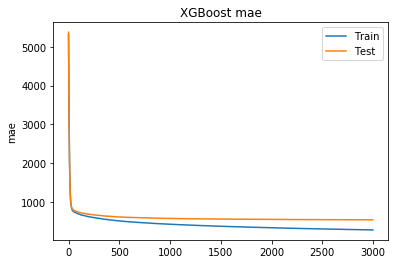

In [89]:
model = xgb_reg
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['mae'])
x_axis = range(0, epochs)

# plot log loss
fig, ax = pyplot.subplots(figsize=(6,4))
ax.plot(x_axis, results['validation_0']['mae'], label='Train')
ax.plot(x_axis, results['validation_1']['mae'], label='Test')
ax.legend()
pyplot.ylabel('mae')
pyplot.title('XGBoost mae')
plt.savefig('mae.png',dpi = 1200)
pyplot.show()

In [17]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

In [46]:
np.sqrt(mean_squared_error(xgb_reg.predict(X_train),y_train)),mean_absolute_error(xgb_reg.predict(X_train),y_train)

(434.16566902807955, 271.1170173622733)

In [47]:
np.sqrt(mean_squared_error(xgb_reg.predict(X_test),y_test)),mean_absolute_error(xgb_reg.predict(X_test),y_test)

(1257.1427365569095, 535.65346297621)

In [43]:
param_test = {
    'max_depth': [7],
    'gamma': [5],
    'reg_alpha': [0.5, 0.7],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.6, 0.7],
    'n_estimators': [3000],
    'learning_rate': [0.1,0.05]
}

gsearch = GridSearchCV(estimator=xgb.XGBRegressor(
    objective='reg:linear',
    eval_metric=["mae"],
#     tree_method='gpu_hist',
#     predictor='gpu_predictor',
#     n_gpus=-1,
    n_jobs = 8,
    min_child_weight=1.1,
    seed=42, early_stopping_rounds= 100),
    param_grid=param_test,
    iid=False,
    cv=5,
    verbose=2)
gsearch.fit(X, y)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=7, n_estimators=3000, reg_alpha=0.5, subsample=0.7 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=7, n_estimators=3000, reg_alpha=0.5, subsample=0.7, total= 2.3min
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=7, n_estimators=3000, reg_alpha=0.5, subsample=0.7 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.3min remaining:    0.0s


[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=7, n_estimators=3000, reg_alpha=0.5, subsample=0.7, total= 2.3min
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=7, n_estimators=3000, reg_alpha=0.5, subsample=0.7 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=7, n_estimators=3000, reg_alpha=0.5, subsample=0.7, total= 2.3min
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=7, n_estimators=3000, reg_alpha=0.5, subsample=0.7 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=7, n_estimators=3000, reg_alpha=0.5, subsample=0.7, total= 2.4min
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=7, n_estimators=3000, reg_alpha=0.5, subsample=0.7 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=7, n_estimators=3000, reg_alpha=0.5, subsample=0.7, total= 2.4min
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=7, n_estimators=3000, reg_alpha=0.5, subsample=0.8 
[CV]

[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=3000, reg_alpha=0.7, subsample=0.7, total= 2.4min
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=3000, reg_alpha=0.7, subsample=0.8 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=3000, reg_alpha=0.7, subsample=0.8, total= 2.4min
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=3000, reg_alpha=0.7, subsample=0.8 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=3000, reg_alpha=0.7, subsample=0.8, total= 2.3min
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=3000, reg_alpha=0.7, subsample=0.8 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=3000, reg_alpha=0.7, subsample=0.8, total= 2.4min
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=3000, reg_alpha=0.7, subsample=0

[CV]  colsample_bytree=0.7, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=3000, reg_alpha=0.5, subsample=0.8, total= 2.7min
[CV] colsample_bytree=0.7, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=3000, reg_alpha=0.5, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=3000, reg_alpha=0.5, subsample=0.8, total= 2.7min
[CV] colsample_bytree=0.7, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=3000, reg_alpha=0.5, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=3000, reg_alpha=0.5, subsample=0.8, total= 2.7min
[CV] colsample_bytree=0.7, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=3000, reg_alpha=0.7, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=3000, reg_alpha=0.7, subsample=0.7, total= 2.7min
[CV] colsample_bytree=0.7, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=3000, reg_alpha=0.7, subsample=0

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 205.2min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bytree=1,
                                    early_stopping_rounds=100,
                                    eval_metric=['mae'], gamma=0,
                                    learning_rate=0.1, max_delta_step=0,
                                    max_depth=3, min_child_weight=1.1,
                                    missing=None, n_estimators=100, n_jobs=8,
                                    nthread=None, objective='reg:linear',
                                    random_state=0, reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=42, silent=True,
                                    subsample=1),
             iid=False, n_jobs=None,
             param_grid={'colsample_bytree': [0.6, 0.7], 'gamma': [5],
                         'learning_rate': [0.1, 0.05], 'max_d

In [48]:
np.sqrt(mean_squared_error(gsearch.predict(X_train),y_train)),mean_absolute_error(gsearch.predict(X_train),y_train)

(383.6656067204381, 232.85432823838053)

In [49]:
np.sqrt(mean_squared_error(gsearch.predict(X_test),y_test)),mean_absolute_error(gsearch.predict(X_test),y_test)

(384.82417640314196, 233.38714276540412)

In [50]:
testA = pd.read_csv('./data/used_car_testA_20200313.csv',sep = ' ')

In [51]:
testA['notRepairedDamage'] = encoder.transform(testA['notRepairedDamage'])

In [52]:
submission = pd.read_csv('./data/used_car_sample_submit.csv')
submission['price'] = gsearch.predict(testA.drop(['SaleID','name'],axis = 1))

In [53]:
submission

,SaleID,price
0,150000,39207.699219
1,150001,256.054901
2,150002,5952.170898
3,150003,11881.668945
4,150004,653.350525
...,...,...
49995,199995,2810.412354
49996,199996,1363.564697
49997,199997,7798.590332
49998,199998,9841.564453


In [54]:
submission.to_csv('submission_3_21_xgb_grid_search.csv',index = False)

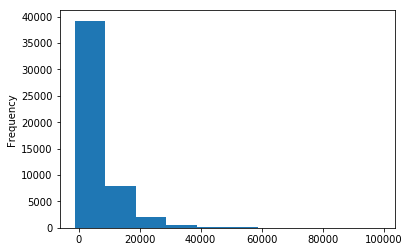

In [112]:
submission.price.plot(kind = 'hist')

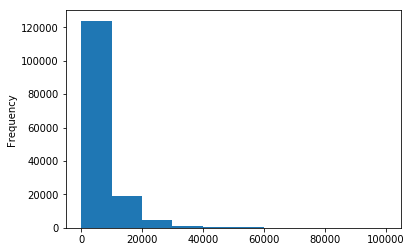

In [111]:
data.price.plot(kind = 'hist')

In [127]:
from sklearn.linear_model import LassoCV

In [172]:
Lasso_model = LassoCV(alphas= np.logspace(-2,0,30),cv= 10,normalize=True,n_jobs = -1)

In [128]:
data.isna().sum()

SaleID                  0
name                    0
regDate                 0
model                   1
brand                   0
bodyType             4506
fuelType             8680
gearbox              5981
power                   0
kilometer               0
notRepairedDamage       0
regionCode              0
seller                  0
offerType               0
creatDate               0
price                   0
v_0                     0
v_1                     0
v_2                     0
v_3                     0
v_4                     0
v_5                     0
v_6                     0
v_7                     0
v_8                     0
v_9                     0
v_10                    0
v_11                    0
v_12                    0
v_13                    0
v_14                    0
dtype: int64

In [154]:
data_clean = data.fillna(value = - 1)

In [155]:
encoder = LabelEncoder()
data_clean['notRepairedDamage'] = encoder.fit_transform(data.notRepairedDamage)

In [156]:
X_train = data_clean.drop(labels= ['SaleID','price'],axis = 1)
y_train = data_clean.price

In [173]:
Lasso_model.fit(X_train,y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1168977065.3725586, tolerance: 765886744.099485
  tol, rng, random, positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1109082517.8125, tolerance: 757107620.3031857
  tol, rng, random, positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1202739980.8916016, tolerance: 762568417.3135406
  tol, rng, random, positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might wan

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1453176474.1923828, tolerance: 759023716.1381336
  tol, rng, random, positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1482306917.928711, tolerance: 762795490.0382618
  tol, rng, random, positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2343626013.6835938, tolerance: 759023716.1381336
  tol, rng, random, positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might 

LassoCV(alphas=array([0.01      , 0.01172102, 0.01373824, 0.01610262, 0.01887392,
       0.02212216, 0.02592944, 0.03039195, 0.03562248, 0.04175319,
       0.04893901, 0.05736153, 0.06723358, 0.07880463, 0.09236709,
       0.10826367, 0.1268961 , 0.14873521, 0.17433288, 0.20433597,
       0.23950266, 0.28072162, 0.32903446, 0.38566204, 0.45203537,
       0.52983169, 0.62101694, 0.72789538, 0.85316785, 1.        ]),
        copy_X=True, cv=10, eps=0.001, fit_intercept=True, max_iter=1000,
        n_alphas=100, n_jobs=-1, normalize=True, positive=False,
        precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
        verbose=False)

In [174]:
np.sqrt(mean_squared_error(Lasso_model.predict(X_train),y_train)),mean_absolute_error(Lasso_model.predict(X_train),y_train)

(4293.747968899664, 2671.8252315847626)

In [194]:
rf = RandomForestClassifier(max_depth=6, random_state=0,n_estimators=50,n_jobs = 8, verbose = 1)

In [181]:
data_clean  = data_clean.fillna(value = -1)

In [182]:
X_train,X_test,y_train,y_test = train_test_split(data_clean.drop(labels = ['SaleID','price'],axis = 1),data_clean.price, 
                                                 test_size = 0.3, random_state = 0, shuffle = True)

In [195]:
rf.fit(X_train,y_train)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   22.4s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:   31.0s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=6, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=8,
                       oob_score=False, random_state=0, verbose=1,
                       warm_start=False)

In [196]:
np.sqrt(mean_squared_error(rf.predict(X_train),y_train)),mean_absolute_error(rf.predict(X_train),y_train)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


KeyboardInterrupt: 

In [ ]:
np.sqrt(mean_squared_error(rf.predict(X_test),y_test)),mean_absolute_error(rf.predict(X_test),y_test)